# Supermarket Sales EDA (Portfolio Project)

**Goal:** Explore supermarket transaction data to understand profitability patterns (gross income) and assess whether customer satisfaction (Rating) relates to profitability.

**Dataset:** Supermarket Sales (Kaggle)  
Source: https://www.kaggle.com/aungpyaeap/supermarket-sales

---

## Executive Summary
This EDA analyzes ~3 months of supermarket sales across three branches.

**Key takeaways (from plots and correlation analysis):**
- Ratings are **broadly uniform** (no strong skew).
- Rating does **not** meaningfully relate to gross income (corr ≈ **-0.04**, regression nearly flat).
- Branch C shows a **slightly higher median** gross income, but branch distributions overlap heavily.
- Gender and payment method show **minimal differences** in gross income distributions.
- Financial variables (Tax/Total/cogs/gross income) are **highly correlated by design** due to being derived from the same calculations.
- Average gross income fluctuates daily with **no clear trend** across the 3-month window.

## Context and Guiding Questions
Supermarket competition is high, and understanding revenue/profit drivers is important for operational decisions.

This notebook answers:
1. What does the distribution of customer ratings look like?
2. Do transaction counts differ across branches?
3. Is gross income related to customer rating?
4. Do branch, gender, or payment method show differences in gross income distribution?
5. Is there a noticeable time trend in gross income?
6. What relationships exist among numeric variables (and which are derived/redundant)?

## Data Dictionary (selected fields)
- **Branch, City**: Store location identifiers  
- **Customer type**: Member vs Normal  
- **Product line**: Category of goods  
- **Unit price, Quantity**: transaction mechanics  
- **Tax 5%, Total, cogs, gross income**: financial fields (some are derived)
- **Rating**: customer satisfaction score (1–10)
- **Date, Time**: purchase timestamp information


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For KDE-style work
from scipy.stats import gaussian_kde

## 1) Load Data

In [ ]:
df = pd.read_csv("supermarket_sales.csv")
df.head(10)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1003 non-null   object 
 1   Branch                   1003 non-null   object 
 2   City                     1003 non-null   object 
 3   Customer type            924 non-null    object 
 4   Gender                   1003 non-null   object 
 5   Product line             960 non-null    object 
 6   Unit price               996 non-null    float64
 7   Quantity                 983 non-null    float64
 8   Tax 5%                   1003 non-null   float64
 9   Total                    1003 non-null   float64
 10  Date                     1003 non-null   object 
 11  Time                     1003 non-null   object 
 12  Payment                  1003 non-null   object 
 13  cogs                     1003 non-null   float64
 14  gross margin percentage 

In [5]:
df.tail()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1.0,3.291,69.111,2/22/19,15:33,Cash,65.82,4.761905,3.291,4.1
999,849-09-3807,A,Yangon,Member,Female,Fashion accessories,88.34,7.0,30.919,649.299,2/18/19,13:28,Cash,618.38,4.761905,30.919,6.6
1000,849-09-3807,A,Yangon,Member,Female,Fashion accessories,88.34,7.0,30.919,649.299,2/18/19,13:28,Cash,618.38,4.761905,30.919,6.6
1001,745-74-0715,A,Yangon,Normal,Male,Electronic accessories,NaN,2.0,5.803,121.863,3/10/19,20:46,Ewallet,116.06,4.761905,5.803,8.8
1002,452-04-8808,B,Mandalay,Normal,Male,Electronic accessories,87.08,NaN,30.478,640.038,1/26/19,15:17,Cash,609.56,4.761905,30.478,5.5


## 2) Data Overview

We inspect columns, data types, and convert the `Date` column to datetime.  
Then we set `Date` as the index to enable time-based grouping.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1003 non-null   object 
 1   Branch                   1003 non-null   object 
 2   City                     1003 non-null   object 
 3   Customer type            924 non-null    object 
 4   Gender                   1003 non-null   object 
 5   Product line             960 non-null    object 
 6   Unit price               996 non-null    float64
 7   Quantity                 983 non-null    float64
 8   Tax 5%                   1003 non-null   float64
 9   Total                    1003 non-null   float64
 10  Date                     1003 non-null   object 
 11  Time                     1003 non-null   object 
 12  Payment                  1003 non-null   object 
 13  cogs                     1003 non-null   float64
 14  gross margin percentage 

In [8]:
# Convert "Date" column to datetime
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].head()

0   2019-01-05
1   2019-03-08
2   2019-03-03
3   2019-01-27
4   2019-02-08
Name: Date, dtype: datetime64[ns]

In [ ]:
# Set "Date" as the index of the DataFrame for time series analysis purposes
df.set_index("Date", inplace=True)
df.head()
df.index

DatetimeIndex(['2019-01-05', '2019-03-08', '2019-03-03', '2019-01-27',
               '2019-02-08', '2019-03-25', '2019-02-25', '2019-02-24',
               '2019-01-10', '2019-02-20',
               ...
               '2019-02-22', '2019-02-18', '2019-01-29', '2019-03-02',
               '2019-02-09', '2019-02-22', '2019-02-18', '2019-02-18',
               '2019-03-10', '2019-01-26'],
              dtype='datetime64[ns]', name='Date', length=1003, freq=None)

In [ ]:
# Basic statistical summary of columns in the DataFrame
df.describe()
df.describe(include=["object"])

,Invoice ID,Branch,City,Customer type,Gender,Product line,Time,Payment
count,1003,1003,1003,924,1003,960,1003,1003
unique,1000,3,3,2,2,6,506,3
top,849-09-3807,A,Yangon,Normal,Female,Fashion accessories,19:48,Ewallet
freq,2,342,342,470,502,172,7,346


## 3) Data Quality Checks

Before analysis:
- Check for duplicate rows and remove them.
- Inspect missing values and apply transparent imputations:
  - numeric columns → mean
  - categorical columns → mode

> This is a simple baseline approach. For heavily skewed numeric columns, median imputation can be a stronger alternative.

In [13]:
# Check for duplicate rows in the DataFrame
df.duplicated().sum()
df[df.duplicated() == True]

# Remove duplicate rows from the DataFrame
df.drop_duplicates(inplace=True)
df.duplicated().sum()


0

In [ ]:
# Check for missing values (rate) in each column of the DataFrame
df.isna().sum() / len(df)


Invoice ID                 0.000
Branch                     0.000
City                       0.000
Customer type              0.079
Gender                     0.000
Product line               0.043
Unit price                 0.006
Quantity                   0.019
Tax 5%                     0.000
Total                      0.000
Time                       0.000
Payment                    0.000
cogs                       0.000
gross margin percentage    0.000
gross income               0.000
Rating                     0.000
dtype: float64

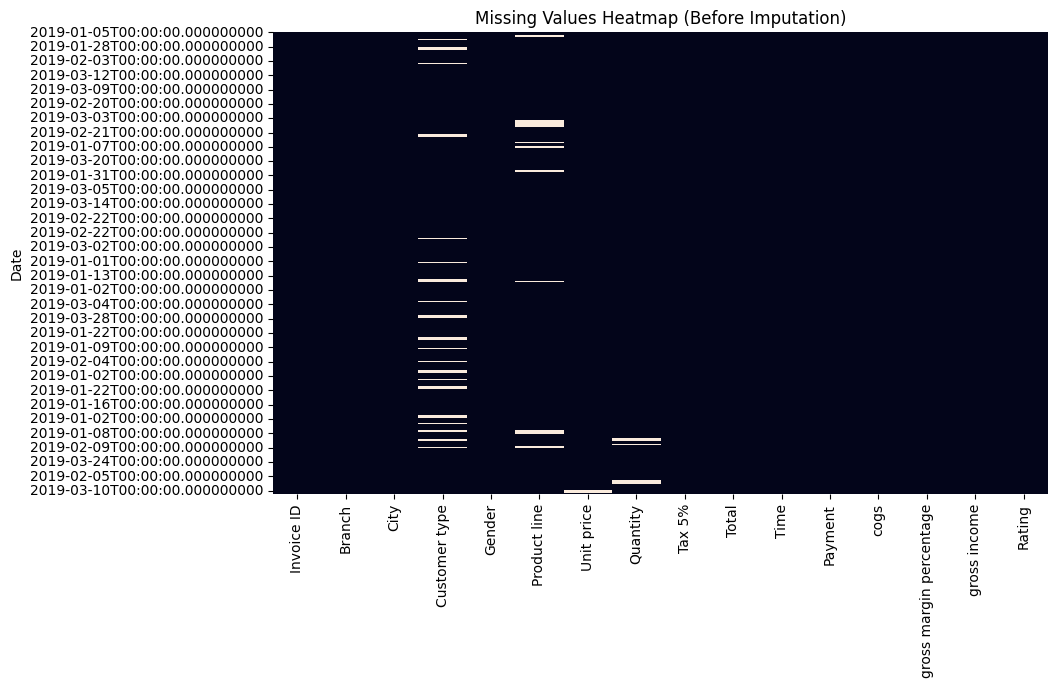

In [16]:
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap (Before Imputation)")
plt.show()


In [18]:
# Impute missing values
num_cols = df.select_dtypes(include="number").columns
# Fill numerical columns with mean
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Fill categorical columns with mode
cat_cols = df.select_dtypes(exclude="number").columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

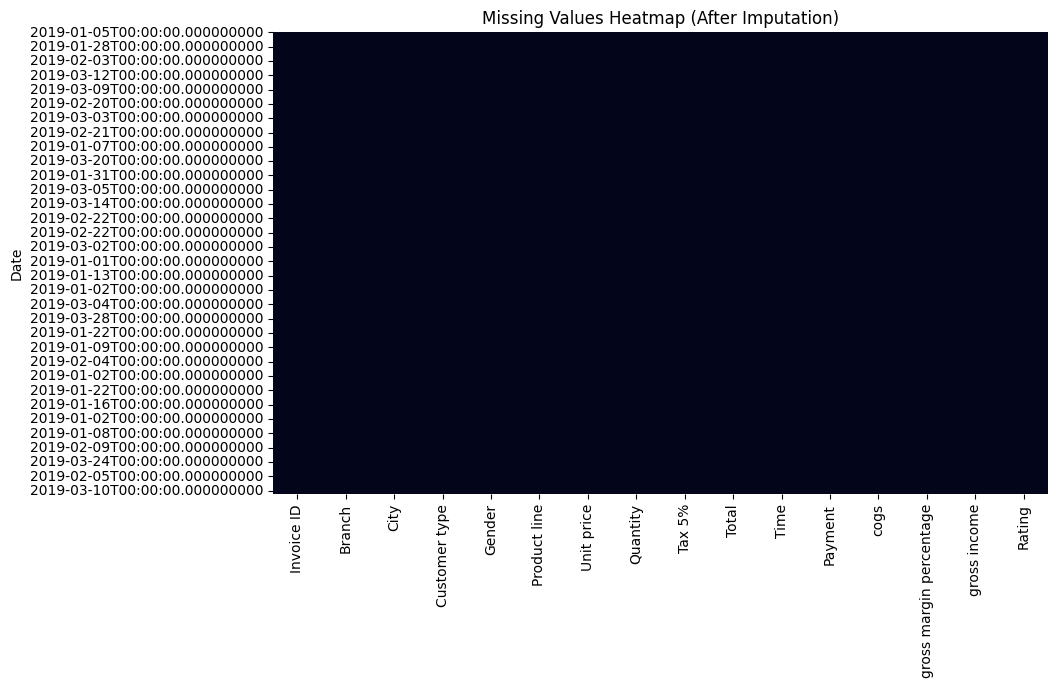

In [19]:
# Visualize missing values after imputation
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap (After Imputation)")
plt.show()

## 4) Univariate Analysis

### 4.1 Distribution of Customer Ratings

The rating distribution looks fairly even across the range shown, with no obvious skew.  
This suggests customer satisfaction is broadly spread rather than concentrated at the low or high end.


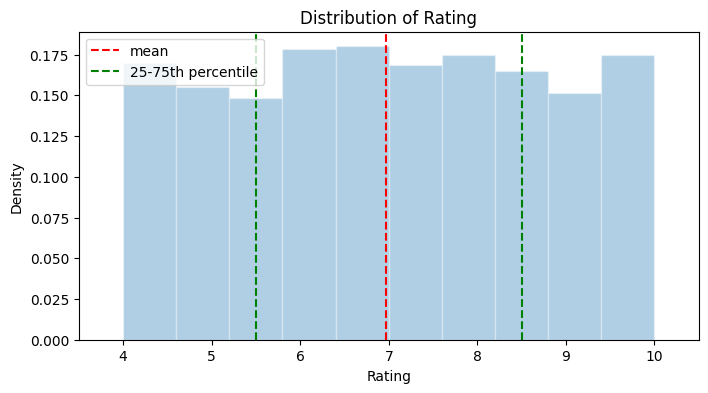

In [ ]:
# Distribution plot for the "Rating" column 
x = df["Rating"].dropna().to_numpy()
mu = x.mean()
q25, q75 = np.percentile(x, [25, 75])

# Plot histogram with mean and percentiles
plt.figure(figsize=(8, 4))
plt.hist(
    x,
    bins=10,
    density=True,
    alpha=0.35,
    edgecolor="white",
    linewidth=1
)

# KDE plot
plt.axvline(mu, color="red", linestyle="--", label="mean")
plt.axvline(q25, color="green", linestyle="--", label="25-75th percentile")
plt.axvline(q75, color="green", linestyle="--")

# Calculate and plot KDE
kde = gaussian_kde(x)
plt.xlabel("Rating")
plt.ylabel("Density")
plt.title("Distribution of Rating")
plt.legend(loc="upper left")
plt.xlim(x.min() - 0.5, x.max() + 0.5)
plt.show()


### 4.2 Distributions of numeric features
**Notes from observed plots:**
- Unit price, Quantity, and Rating appear closer to uniform.
- Tax/Total/COGS/Gross income are right-skewed.
- Gross margin percentage appears constant (no meaningful variation).

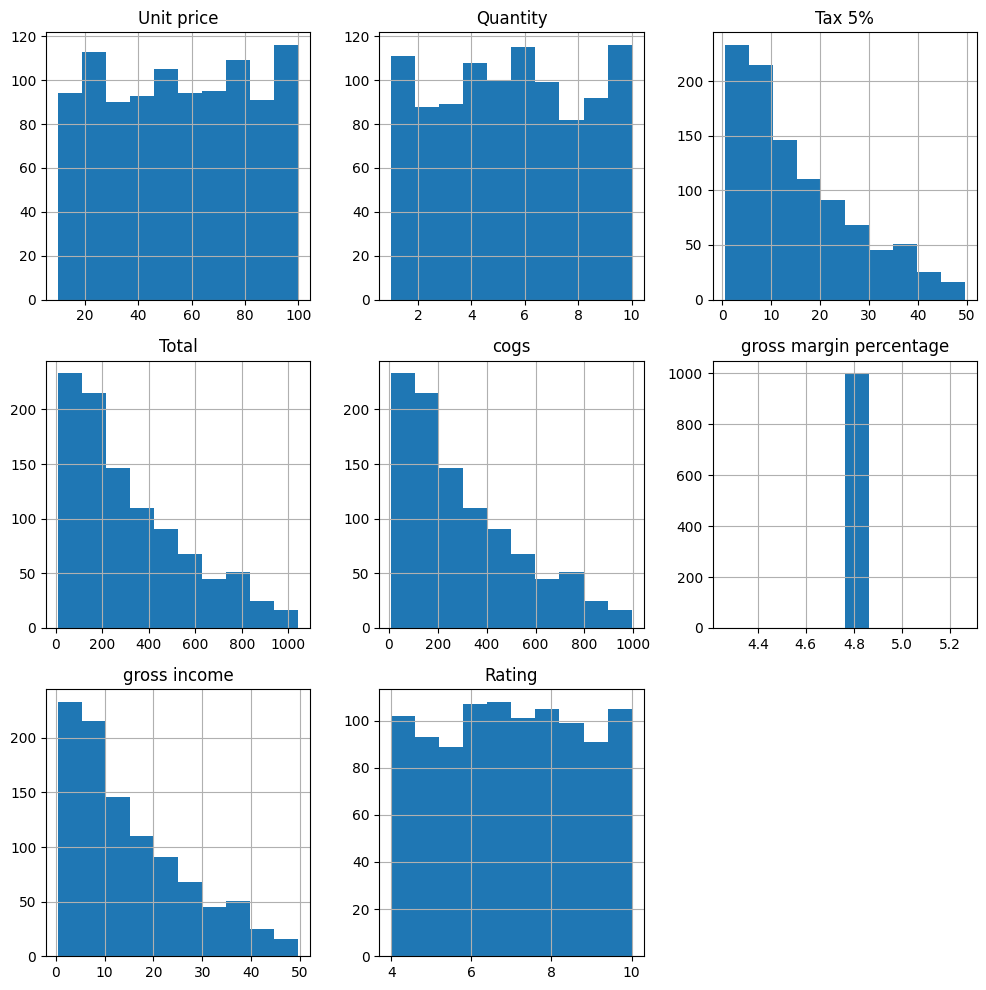

In [43]:
# Histograms and pair plots for all numerical columns
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

### 4.3 Transaction counts by branch
**Finding:** Transaction counts are similar across branches; Branch A is slightly higher.

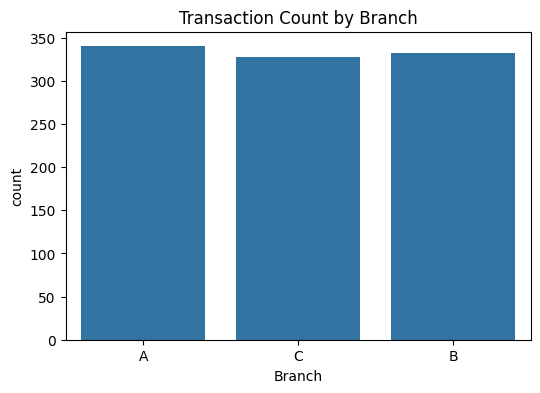

<Axes: xlabel='City', ylabel='count'>

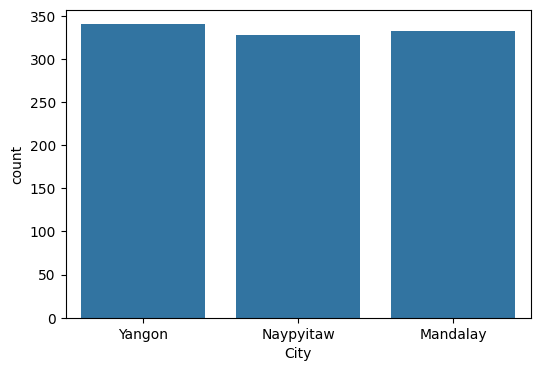

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x="Branch", data=df)
plt.title("Transaction Count by Branch")
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="City", data=df)

In [26]:
# Count of transactions by branch
df["Branch"].value_counts()

Branch
A    340
B    332
C    328
Name: count, dtype: int64

### 4.4 Payment method distribution

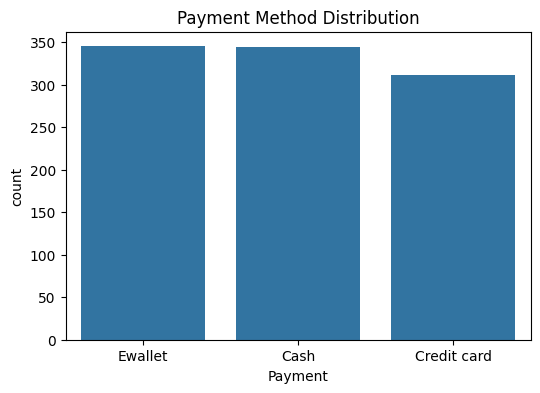

In [ ]:
# Count of transactions by payment method
plt.figure(figsize=(6, 4))
sns.countplot(x="Payment", data=df)
plt.title("Payment Method Distribution")
plt.show()

## 5) Bivariate Analysis

### 5.1 Rating vs Gross Income (Scatter + Regression Overlay)

The scatter is highly dispersed and the regression overlay is nearly flat.  
This supports the correlation result (~ **-0.04**): customer rating does not appear to meaningfully explain gross income per transaction in this dataset.


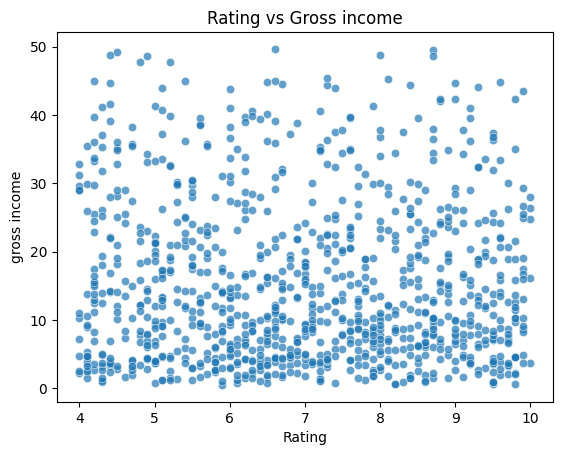

In [ ]:
# Scatter plot of "Rating" vs "gross income"
sns.scatterplot(x="Rating", y="gross income", data=df, alpha=0.7)
plt.title("Rating vs Gross income")
plt.show()

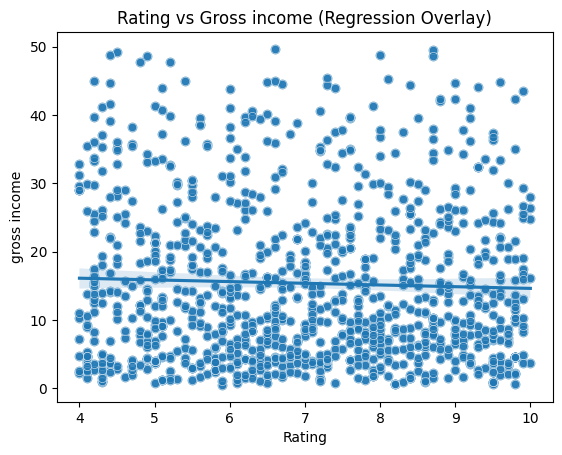

In [ ]:
# Scatter plot with regression line overlay
sns.regplot(x="Rating", y="gross income", data=df)
sns.scatterplot(x="Rating", y="gross income", data=df, alpha=0.7)
plt.title("Rating vs Gross income (Regression Overlay)")
plt.show()


### 5.2 Gross Income by Branch / Gender

- **Branch:** Distributions overlap heavily; Branch C appears slightly higher in median gross income, but differences are modest.
- **Gender:** Female median appears slightly higher, though overlap is large.

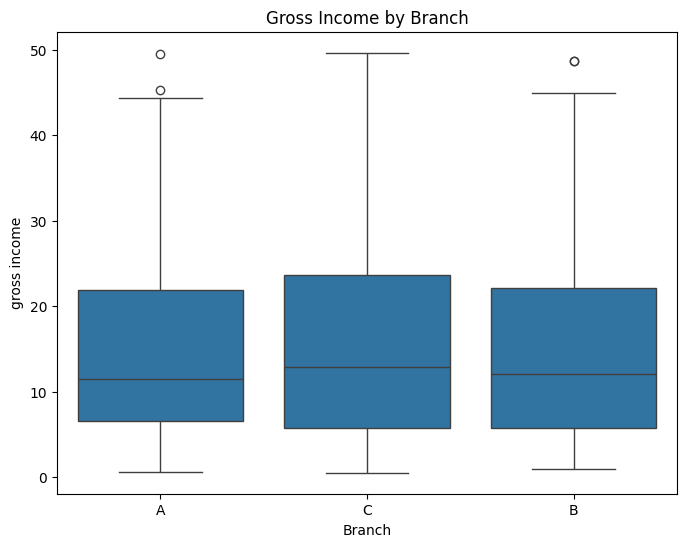

In [31]:
# Box plot of "gross income" by "Branch"
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Branch"], y=df["gross income"])
plt.title("Gross Income by Branch")
plt.show()

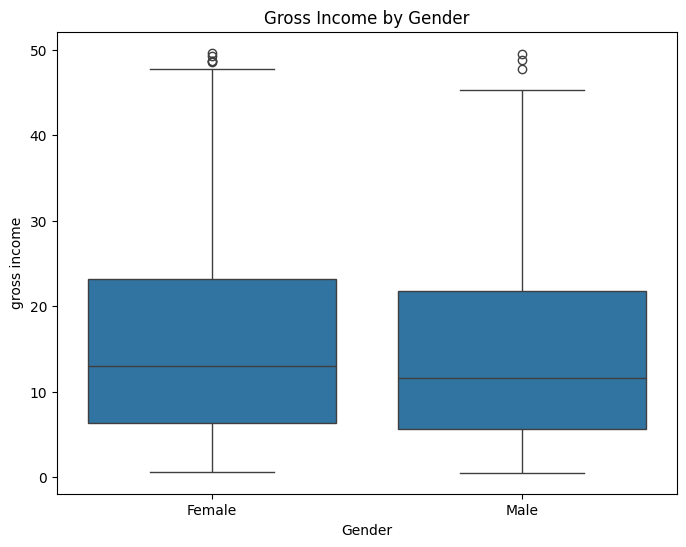

In [44]:
# Box plot of gross income by Gender
plt.figure(figsize=(8, 6))
sns.boxplot(x=df["Gender"], y=df["gross income"])
plt.title("Gross Income by Gender")
plt.show()

## 6) Time Series: Average Gross Income Over Time

**What the plot shows:**
- Average gross income fluctuates noticeably day-to-day with occasional spikes and dips.
- Over the observed 3-month window, there is **no clear sustained upward or downward trend**.

**Interpretation:**
- Short time horizon + daily volatility suggests that deeper time features (day-of-week, hour-of-day, holidays/promotions if available) would be needed to explain the fluctuations.

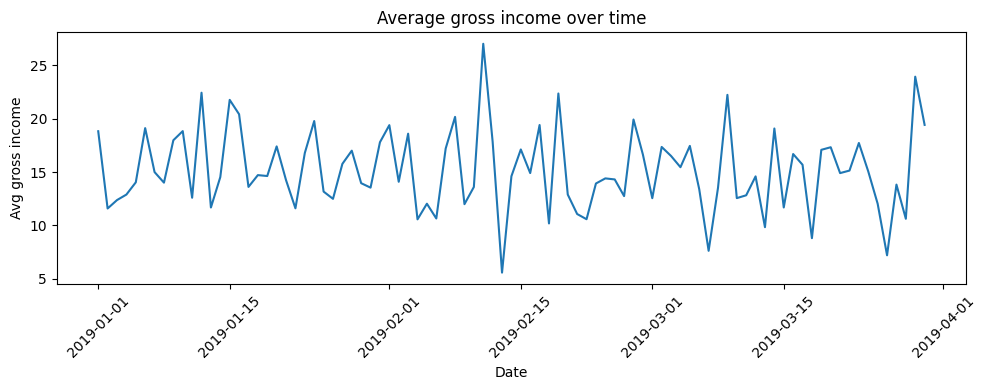

In [ ]:
# Time series plot of average gross income over time
daily = df.groupby(df.index)["gross income"].mean()

plt.figure(figsize=(10, 4))
plt.plot(daily.index, daily.values)
plt.xlabel("Date")
plt.ylabel("Avg gross income")
plt.title("Average gross income over time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 7) Pairwise Relationships (Numeric Features)

**What the pairwise plot shows:**
- Clear linear structure among **Tax 5%**, **Total**, **COGS**, and **gross income**—these relationships are expected because they are **directly derived** from one another.
- **Gross margin percentage** appears nearly constant, which contributes little analytical value and can create plotting warnings or degenerate axes.
- Rating shows weak/no clear relationships with most numeric variables.

**Interpretation:**
- For analysis/modeling, it’s important to recognize derived columns; including all of them together can be redundant and misleading.

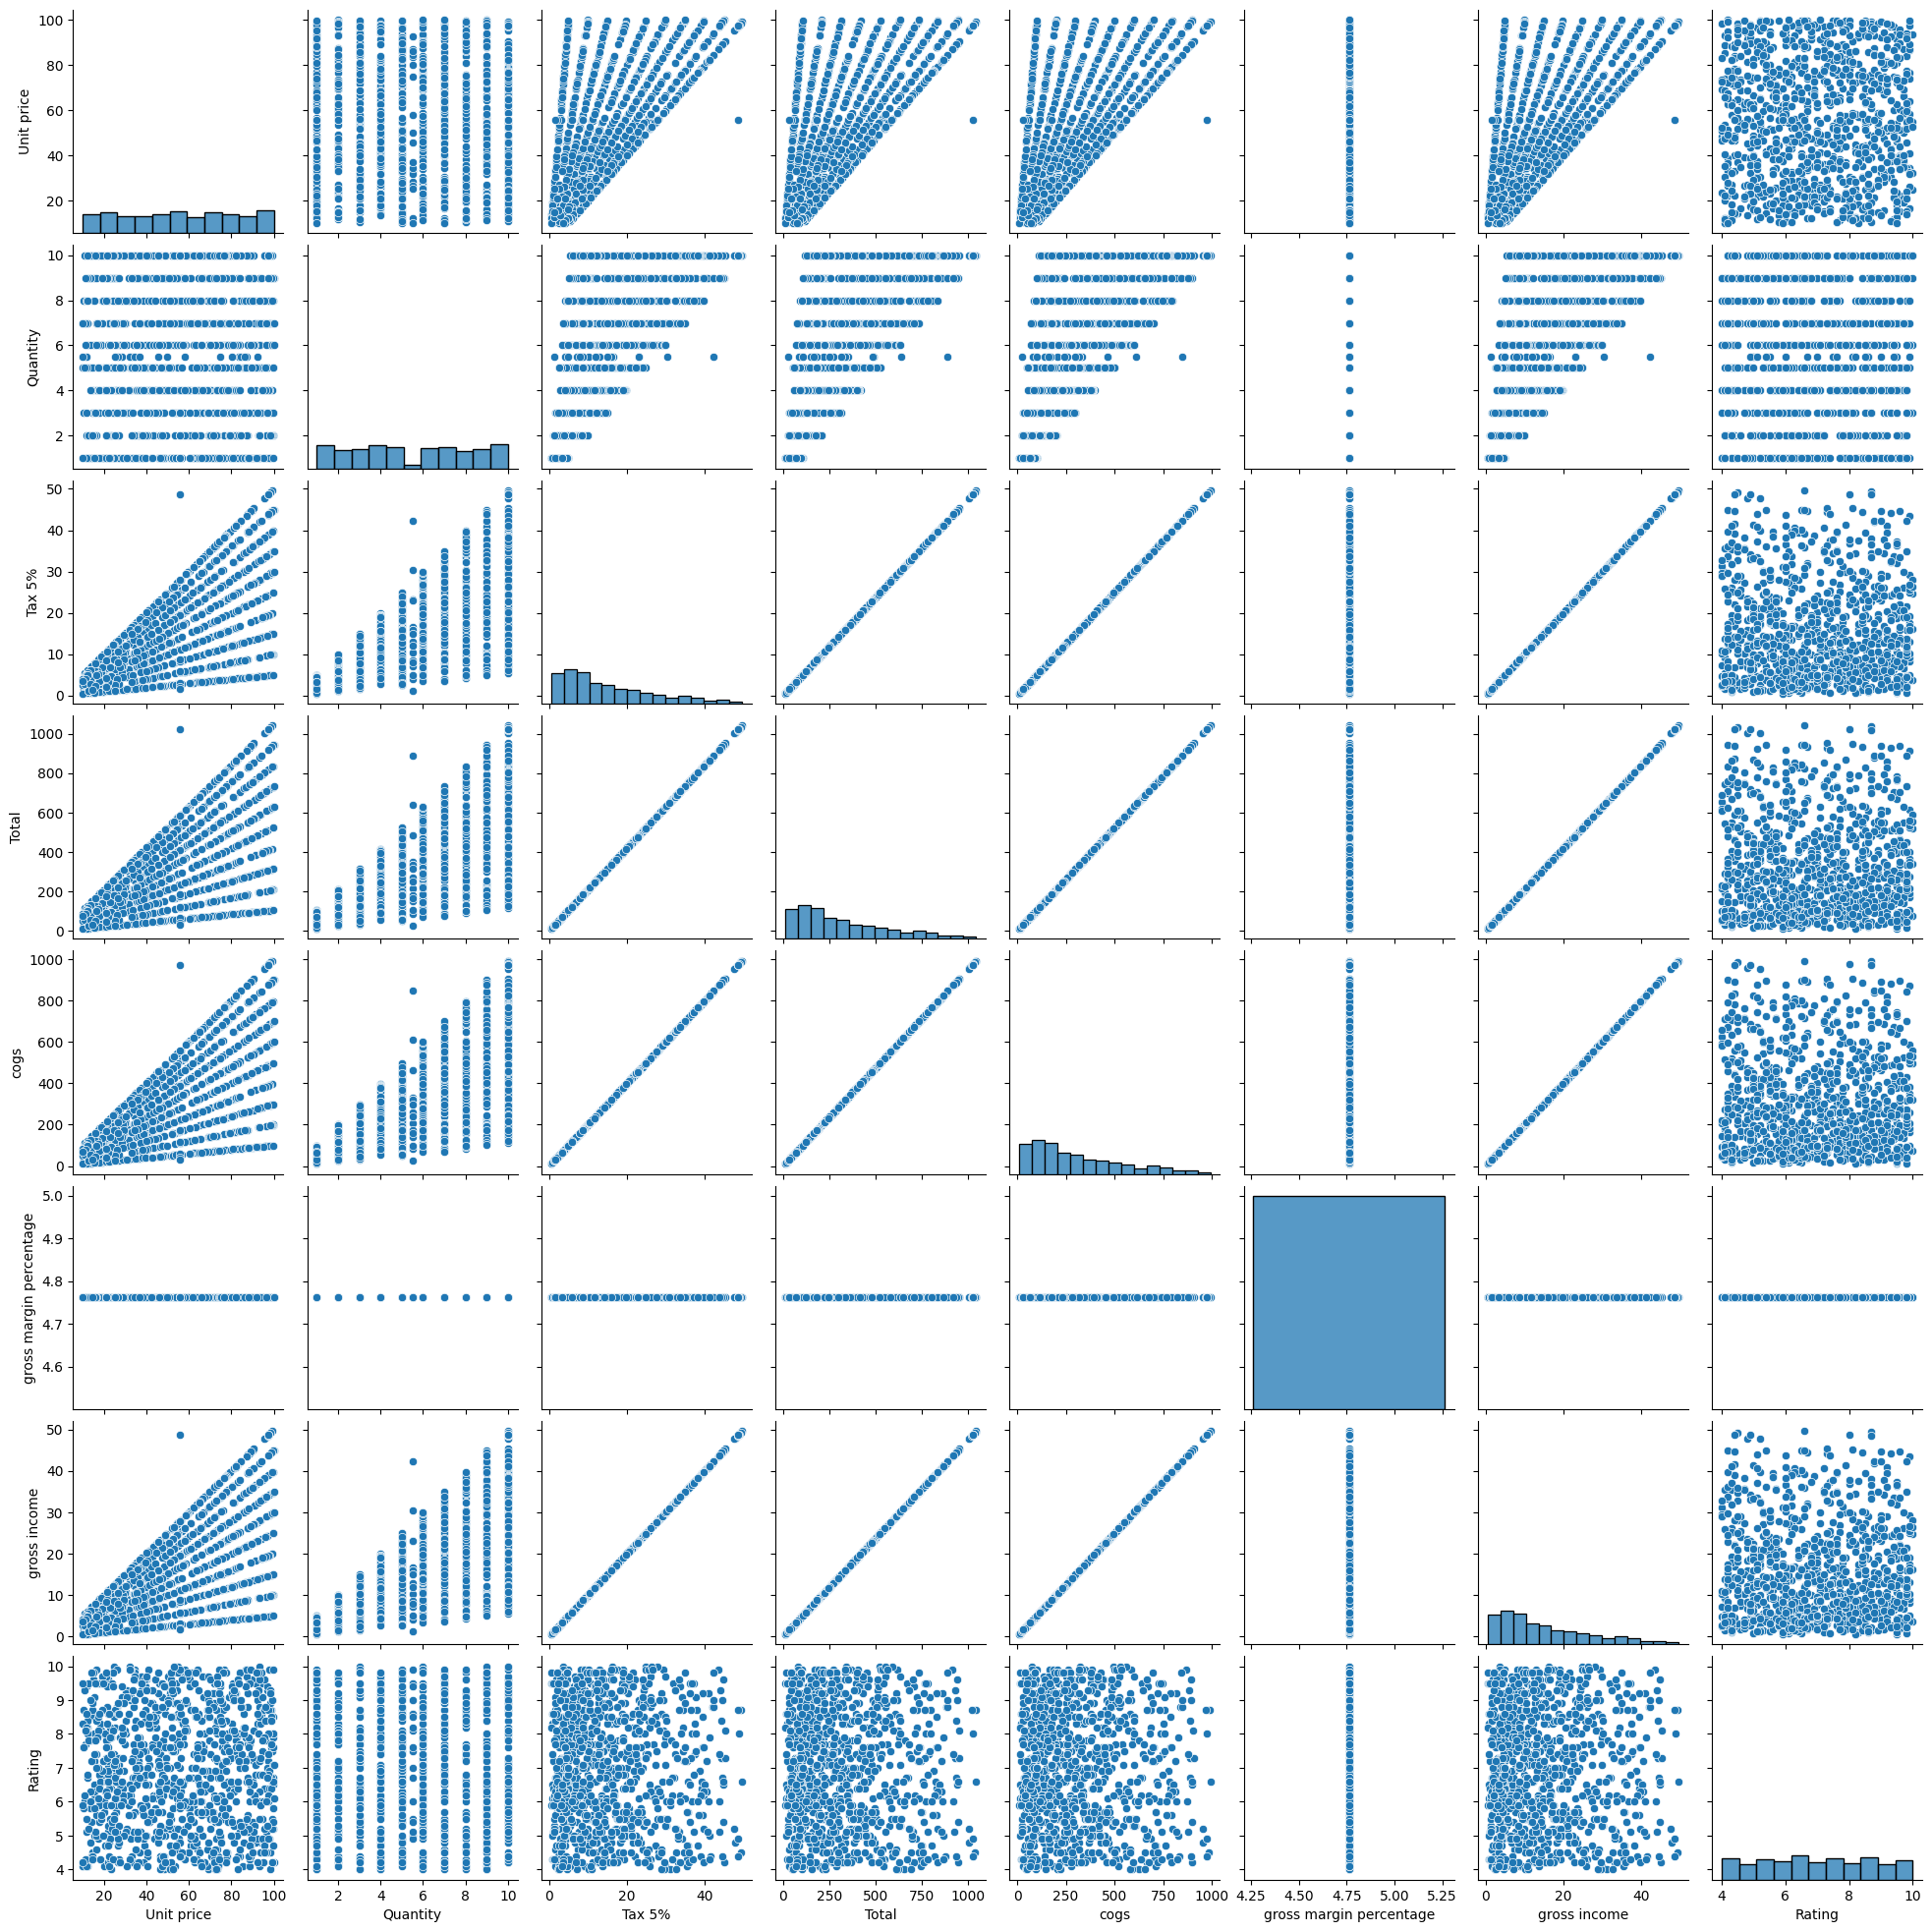

In [37]:
# Scatter plot matrix for numerical columns
sns.pairplot(df)
plt.show()

## 8) Correlation Analysis

### 8.1 Correlation between gross income and rating
**Finding:** ≈ -0.04 → essentially no linear relationship.

In [38]:
# Correlation coefficient between "gross income" and "Rating"
round(np.corrcoef(df["gross income"], df["Rating"])[1][0], 2)

-0.04

## 8.3 Correlation Matrix (Numeric Features)

**What the heatmap shows:**
- **Tax 5%**, **Total**, **COGS**, and **gross income** have near-perfect correlations (~1.00). This is expected because they are constructed from the same underlying calculation.
- Rating has very weak correlations with financial outcomes (e.g., around **-0.04** with gross income / totals).

**Interpretation:**
- Strong correlations among derived financial columns should not be interpreted as “insights” about customer behavior.
- The weak rating correlation reinforces what’s seen in the scatter/regression plots: rating is not a useful predictor of profitability here.


In [41]:
# Correlation matrix for numerical columns
corr = np.round(df.corr(numeric_only=True), 2)
corr

,Unit price,Quantity,Tax 5%,Total,cogs,gross margin percentage,gross income,Rating
Unit price,1.00,0.01,0.63,0.63,0.63,NaN,0.63,-0.01
Quantity,0.01,1.00,0.70,0.70,0.70,NaN,0.70,-0.02
Tax 5%,0.63,0.70,1.00,1.00,1.00,NaN,1.00,-0.04
Total,0.63,0.70,1.00,1.00,1.00,NaN,1.00,-0.04
cogs,0.63,0.70,1.00,1.00,1.00,NaN,1.00,-0.04
gross margin percentage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gross income,0.63,0.70,1.00,1.00,1.00,NaN,1.00,-0.04
Rating,-0.01,-0.02,-0.04,-0.04,-0.04,NaN,-0.04,1.00


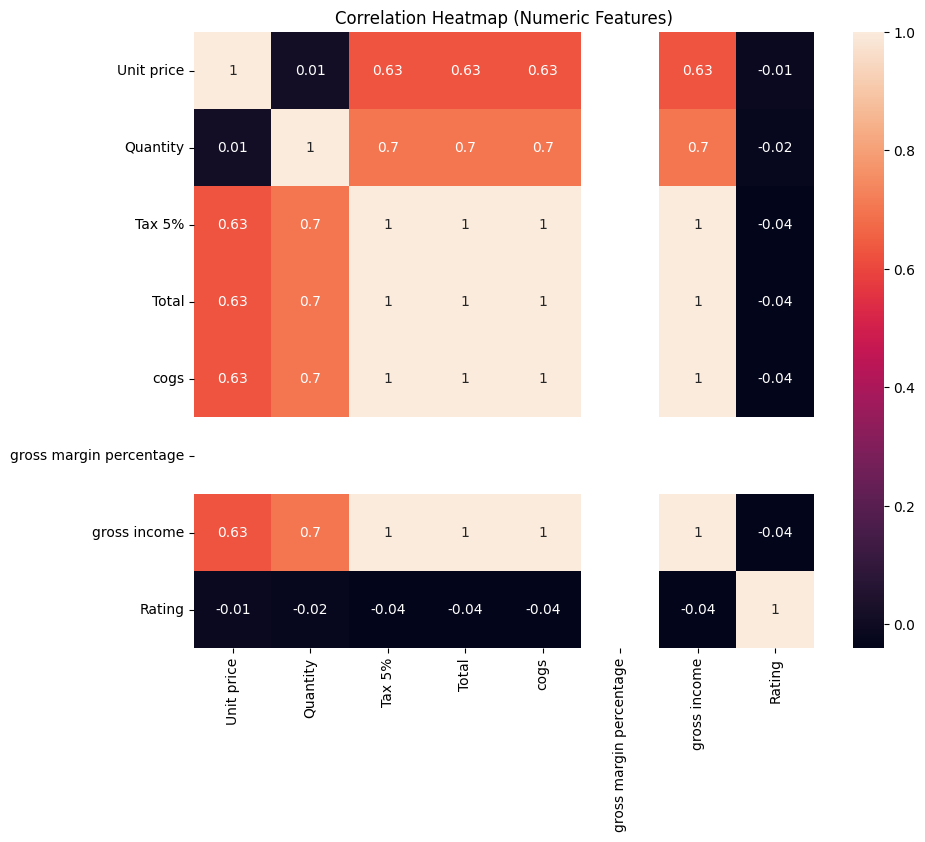

In [42]:
# Correlation heatmap for numerical columns
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


## Final Takeaways
- Ratings are broadly uniform and do not show strong skew.
- Rating does not meaningfully relate to gross income (corr ≈ -0.04).
- Branches show similar gross income distributions; Branch C has a slightly higher median but overlap is substantial.
- Gender and payment method differences are minimal.
- Tax/Total/cogs/gross income are highly correlated by design and should be treated as derived/redundant in analysis or modeling.
- Average gross income fluctuates daily with no clear trend over the observed period.

### Next Steps (optional)
- Segment profitability by product line, customer type, city, and branch.
- Add time features (hour-of-day, day-of-week) for operational insights.
- (Optional) Build a simple predictive model using independent predictors and excluding redundant derived measures.